# Decision Trees Lab

In this lab we will discover how to apply decision trees to regression and classification problems.

## 1: Build a regression tree

How do you build a decision tree? You're going to find out by building one in pairs.

Your training data is a tiny dataset of [used vehicle sale prices](../../assets/datasets/used_cars.csv). Your goal is to predict Price for out-of-sample data. 

---

## 1.1 Manually build the decision tree

Here are your instructions:

1. Read the data into Pandas.
2. Explore the data by sorting, plotting, or split-apply-combine (aka `group_by`).
3. Decide which feature is the most important predictor, and use that to make your first split. (Only binary splits are allowed!)
4. After making your first split, you should actually split your data in Pandas into two parts, and then explore each part to figure out what other splits to make.
5. Decide if you need additional splits along other features
6. Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting. (As always, your goal is to build a model that generalizes well.)
    - Note: You are allowed to split on the same variable multiple times!
7. Draw your tree on a piece of paper or describe in in a markdown cell. Label your leaves with the mean Price for the observations in that "bucket".
8. When you're finished, review your tree to make sure nothing is backwards. (Remember: follow the left branch if the rule is true, and follow the right branch if the rule is false.)

In [65]:
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [15]:
df = pd.read_csv("../../assets/datasets/used_cars.csv")

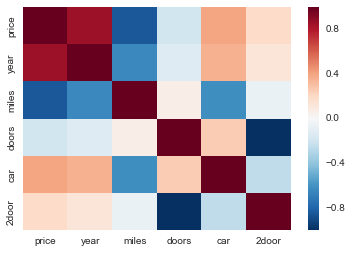

In [39]:
sns.heatmap(df.corr())

In [34]:
df_car = df.groupby('type')['price'].mean()

df_car = pd.DataFrame(df_car).reset_index()
df_car

,type,price
0,car,7790.909091
1,truck,2100.000000


In [35]:
df_doors = df.groupby('doors')['price'].mean()

df_doors = pd.DataFrame(df_doors).reset_index()
df_doors

,doors,price
0,2,7883.333333
1,4,5587.500000


In [37]:
df['car'] = df['type'].map(lambda x: 1 if x == 'car' else 0)
df['2door'] = df['doors'].map(lambda x: 1 if x == 2 else 0)

In [73]:
# del df['doors']
# del df['type']
df

,price,year,miles,car,2door
0,22000,2012,13000,1,1
1,14000,2010,30000,1,1
2,13000,2010,73500,1,0
3,9500,2009,78000,1,0
4,9000,2007,47000,1,0
5,4000,2006,124000,1,1
6,3000,2004,177000,1,0
7,2000,2004,209000,0,0
8,3000,2003,138000,1,1
9,1900,2003,160000,1,0


---

## How does a computer build a regression tree?

The ideal approach would be for the computer to consider every possible partition of the feature space. However, this is computationally infeasible, so instead an approach is used called **recursive binary splitting:**

- Begin at the top of the tree.
- For every single predictor, examine every possible cutpoint, and choose the predictor and cutpoint such that the resulting tree has the **lowest possible mean squared error (MSE)**. Make that split.
- Repeat the examination for the two resulting regions, and again make a single split (in one of the regions) to minimize the MSE.
- Keep repeating this process until a stopping criteria is met.

**How does it know when to stop?**

1. We could define a stopping criterion, such as a **maximum depth** of the tree or the **minimum number of samples in the leaf**.
2. We could grow the tree deep, and then "prune" it back using a method such as "cost complexity pruning" (aka "weakest link pruning").

Method 2 involves setting a tuning parameter that penalizes the tree for having too many leaves. As the parameter is increased, branches automatically get pruned from the tree, resulting in smaller and smaller trees. The tuning parameter can be selected through cross-validation.

Note: **Method 2 is not currently supported by scikit-learn**, and so we will use Method 1 instead.


## 2: Build a regression tree in scikit-learn

---

### 2.a Use sklearn to construct the decision tree

Building a tree by hand was not so easy, and also not ideal. Use scikit-learn to build an optimal regression tree. Do the following:

1. Map the `type` column to a binary variable
2. Create a matrix `X` that contains the feature values and a vector `y` that contains the price values
3. Split the data into train-test using a random state of 42 and test_size of 30%
4. Import and initialize the `DecisionTreeRegressor` class from scikit-learn
5. Fit it to the training set
6. Predict the values of the test set
7. Display the predicted and actual values in a plot
8. Use r2_score to judge the goodness of fit for the regression

In [96]:
X = [x for x in df.columns if x != 'price']
Y = df.price

In [97]:
X = df[X]

In [98]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [127]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import sklearn.datasets as datasets

# criterion: splitting decision function (discussed later), can be 'gini' or 'entropy'
# max_depth: the maximum number of hierarchical decision nodes (how "deep" the tree is built)
#
# classifier = DecisionTreeClassifier(criterion='gini',
#                                     max_depth=None)

regressor = DecisionTreeRegressor(criterion='mse',
                                  max_depth=5)

regressor.fit(X_train, Y_train)

Y_pred = regressor.predict(X_test)
# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = regressor.feature_importances_

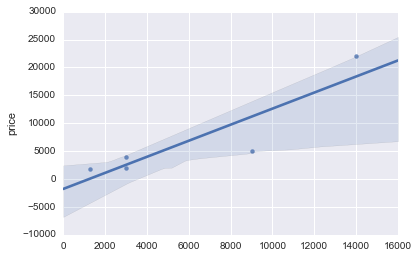

In [129]:
sns.regplot(x = Y_pred, y = Y_test)

---

### 2.b Examine effect of different parameters

The `DecisionTreeRegressor` offers few global parameters that can be changed at initialization. For example one can set the `max_depth` or the `min_samples_leaf` parameters and impose global constraints on the space of solutions.

1. Use `cross_val_score` with 3-fold cross validation to find the optimal value for the `max_depth` (explore values 1 - 10). 
    - Set `scoring='mean_squared_error'` as criterion for score. 
    - Set `random_state=1`
2. Plot the error as a function of `max_depth` (max_depth on x axis, error on y axis)

This code will get you the error:

```python
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
current_error = np.mean(np.sqrt(-scores))
```

---

## 2.c Feature importances

The decision tree class exposes an attribute called `feature_importances_`.

1. Check the importance of each feature. what's the most important feature?

---

### 2.d Tree visualization

Follow the example in the [documentation](http://scikit-learn.org/stable/modules/tree.html) to visualize the tree.

You may have to install `pydot2` and `graphviz` if you don't have them already. (I can help with this).

### Interpreting a tree diagram

How do we read this decision tree?

**Internal nodes:**

- `samples` is the number of observations in that node before splitting
- `mse` is the mean squared error calculated by comparing the actual response values in that node against the mean response value in that node
- First line is the condition used to split that node (go left if true, go right if false)

**Leaves:**

- `samples` is the number of observations in that node
- `value` is the mean response value in that node
- `mse` is the mean squared error calculated by comparing the actual response values in that node against "value"

---

### Exercise 3: Use GridSearchCV to find the best Regression Tree

How do we know by pruning with max depth is the best model for us? Trees offer a variety of ways to pre-prune (that is, we tell a computer how to design the resulting tree with certain "gotchas").

Measure           | What it does
------------------|-------------
max_depth         | How many nodes deep can the decision tree go?
max_features      | Is there a cut off to the number of features to use?
max_leaf_nodes    | How many leaves can be generated per node?
min_samples_leaf  | How many samples need to be included at a leaf, at a minimum?  
min_samples_split | How many samples need to be included at a node, at a minimum?

1. Initialize reasonable ranges for all parameters and find the optimal combination using Grid Search.

**To calculate best score, you need to use code:**

```python
print np.sqrt(-clf.best_score_)
```

---

## 4. Classification trees

Classification trees are very similar to regression trees. Here is a quick comparison:

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize a different criterion (discussed below)|

Note that classification trees easily handle **more than two response classes**! (How have other classification models we've seen handled this scenario?)

Here's an **example of a classification tree**, which predicts whether or not a patient who presented with chest pain has heart disease:

---

### 4.a Build a classification tree in scikit-learn

We'll build a classification tree using the [Car Dataset](./assets/datasets/cars.csv).

1. Load the dataset in pandas
2. Check for missing values
3. Encode all the categorical features to booleans using `pd.get_dummies`
4. Encode the labels using LabelEncoder
5. Split X and y with train_test split like above
        train_test_split(X, y, test_size=0.3, random_state=42)
6. Fit a classification tree with `max_depth=3` on all data
7. Visualize the tree using graphviz
8. Compute the feature importances
9. Compute and display the confusion matrix (use sklearn function)
10. Release the constraint of `max_depth=3` by setting `max_depth=None` and see if the classification improves using cross-validation

---

## [BONUS] 5. Classification tree visualization

Visualize the last tree you build that had `max_depth=None`. Can you make sense of it? What does this teach you about decision tree interpretability?
